In [14]:
from FetalECGExtractor import FetalECGExtractor
from pipeline_functions import preprocess_signal, extract_and_analyze, load_ground_truth, plot_results, debug_plot_overlay, load_and_interpolate, construct_s6_signal, calculate_snr_sir, calculate_paper_metrics, evaluate_performance
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

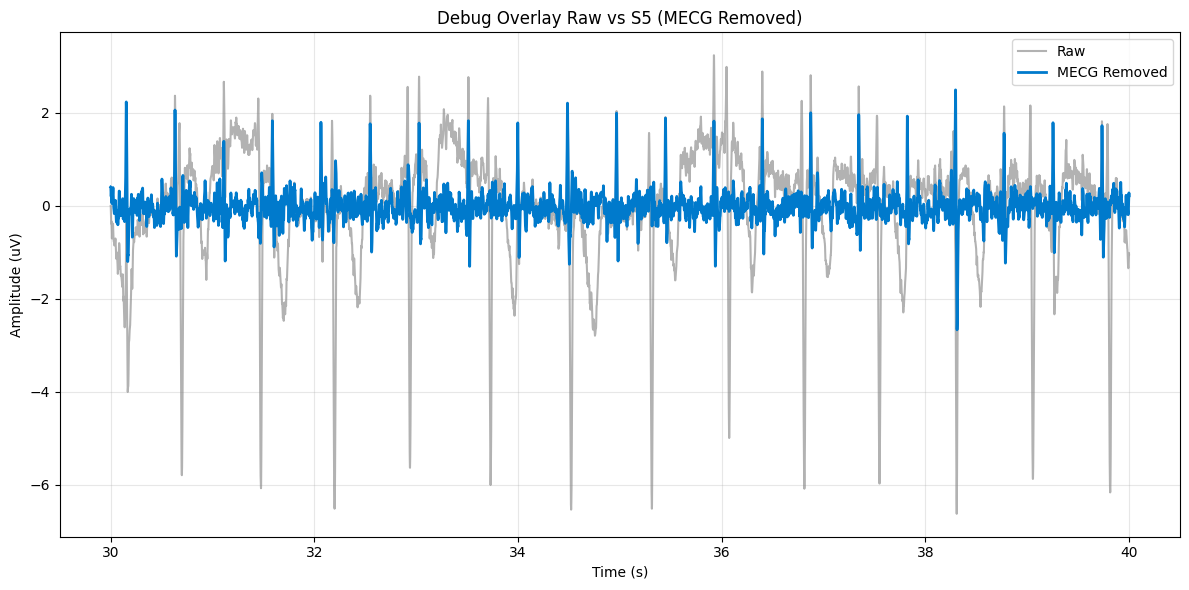

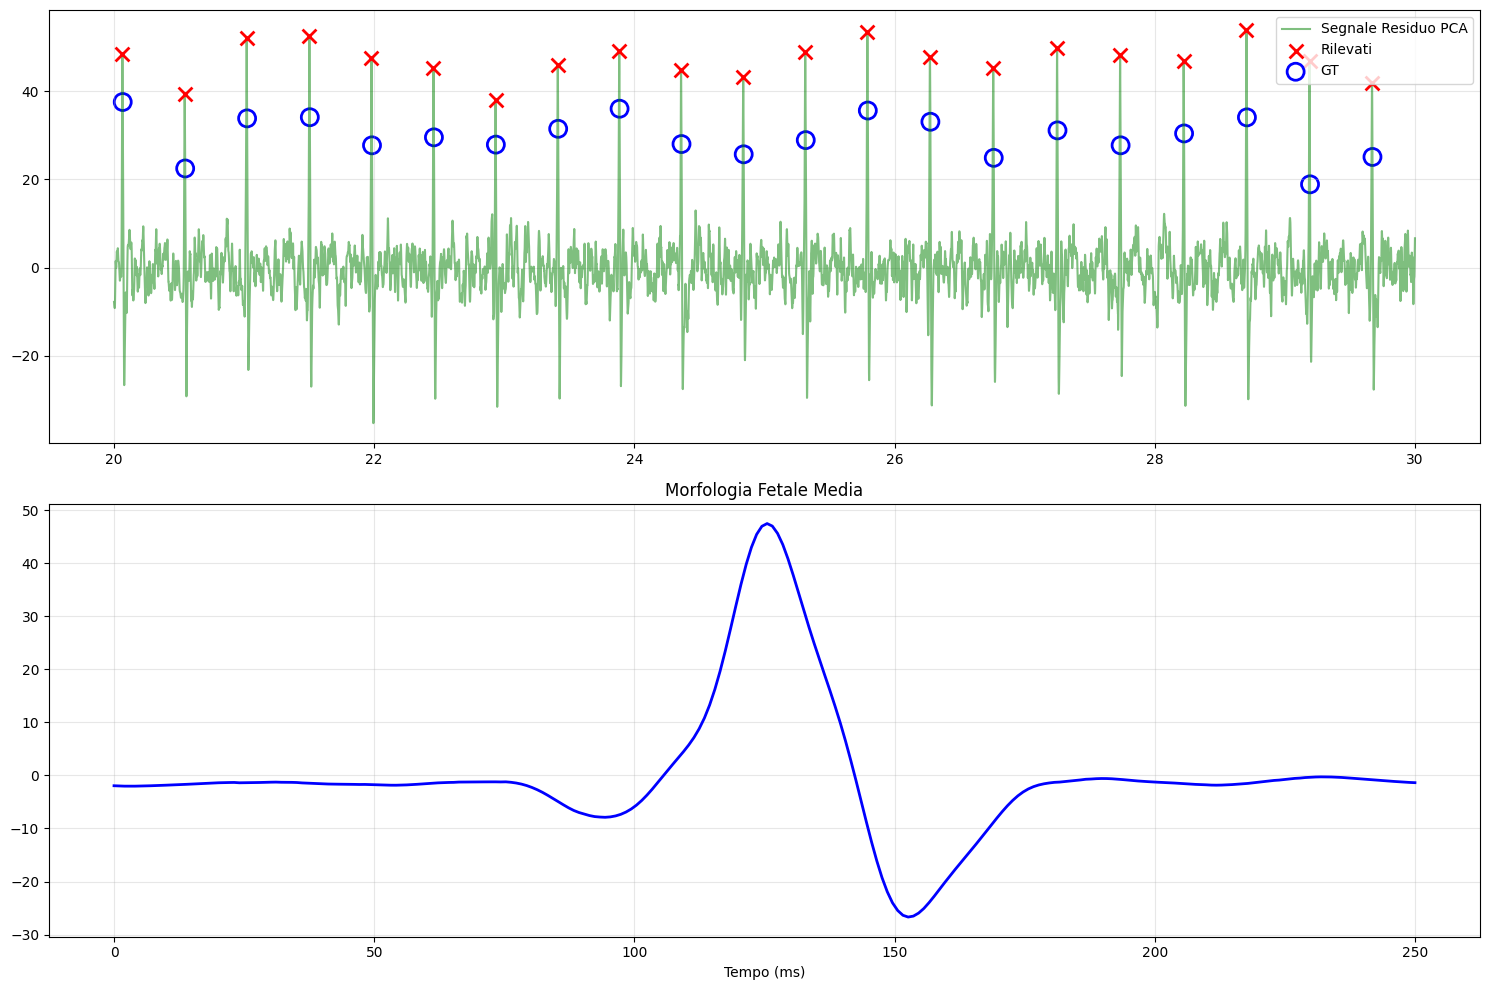

In [8]:
BASE_PATH = './data/set_a/'
record_list = [f"a{i:02d}" for i in range(1, 26)]
TARGET_FS = 2000
OUTPUT_CSV = "risultati_metriche.csv"

header = ['REC', 'BPM', 'Reliability', 'SNR', 'SIR']
with open(OUTPUT_CSV, mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(header)

fetal_extractor = FetalECGExtractor(TARGET_FS)

for rec_name in record_list:
    
    full_path = os.path.join(BASE_PATH, rec_name)
    try:
        raw, fields = load_and_interpolate(full_path)
        fs_native = fields['fs']
        n_samples = raw.shape[0]
        
        # 1. Preprocessing
        S5, S4, up_factor = preprocess_signal(raw, fs_native, TARGET_FS)
        
        # 2. Estrazione
        best_signal, f_peaks = extract_and_analyze(S5, fetal_extractor, TARGET_FS)
        if rec_name == "a22":
            gt_peaks, _ = load_ground_truth(full_path, n_samples, up_factor)
            debug_plot_overlay(raw, fs_native, S5, TARGET_FS, title="Debug Overlay Raw vs S5 (MECG Removed)", start_s=30, duration_s=10, channel_idx=0)
            plot_results(rec_name, best_signal, f_peaks, gt_peaks, fetal_extractor, TARGET_FS)
        
        # 3. Calcolo S6 e Metriche di Qualità
        S6 = construct_s6_signal(S5, f_peaks, TARGET_FS)
        snr, sir = calculate_snr_sir(S4, S5, S6)
        
        seg_len_up = n_samples * up_factor
        rel, bpm, success = calculate_paper_metrics(f_peaks, TARGET_FS, seg_len_up)
        
        with open(OUTPUT_CSV, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                rec_name, 
                f"{bpm:.2f}", 
                f"{rel:.4f}", 
                f"{snr:.2f}", 
                f"{sir:.2f}"
            ])

    except Exception as e:
        print(f"Error processing {rec_name}: {e}")
        with open(OUTPUT_CSV, mode='a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([rec_name, "ERROR", "0", "-99", "-99"])

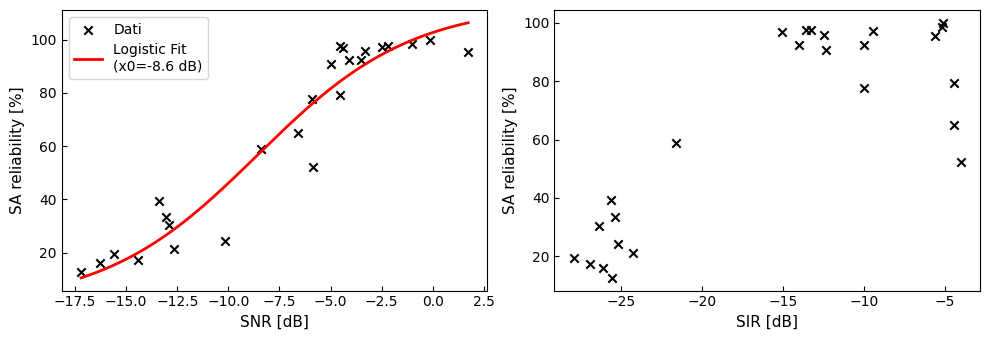

In [ ]:
df. = pd.read_csv(OUTPUT_CSV)
df['Reliability_Pct'] = df['Reliability'] * 100

def logistic_func(x, L, x0, k):
    return L / (1 + np.exp(-k * (x - x0)))

df_sorted = df.sort_values(by='SNR')
x_data = df_sorted['SNR'].values
y_data = df_sorted['Reliability_Pct'].values

p0 = [100, np.median(x_data), 1]

try:
    popt, pcov = curve_fit(logistic_func, x_data, y_data, p0=p0, maxfev=5000)
    x_fit = np.linspace(min(x_data), max(x_data), 500)
    y_fit = logistic_func(x_fit, *popt)
    fit_label = f'Logistic Fit\n(x0={popt[1]:.1f} dB)'
except Exception as e:
    print(e)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.5))

ax1.scatter(df['SNR'], df['Reliability_Pct'], marker='x', color='black', label='Dati')
if len(x_fit) > 0:
    ax1.plot(x_fit, y_fit, color='red', linewidth=2, label=fit_label)
    ax1.legend()

ax1.set_xlabel('SNR [dB]', fontsize=11)
ax1.set_ylabel('SA reliability [%]', fontsize=11)
ax1.tick_params(direction='in')

ax2.scatter(df['SIR'], df['Reliability_Pct'], marker='x', color='black')
ax2.set_xlabel('SIR [dB]', fontsize=11)
ax2.set_ylabel('SA reliability [%]', fontsize=11)
ax2.tick_params(direction='in')

# 4. Final Display
plt.tight_layout()
plt.show()

In [6]:
corr_matrix = df[['Reliability', 'SNR', 'SIR']].corr(method='spearman')
print("\nSpearman Correlation Matrix:")
print(corr_matrix)


Spearman Correlation Matrix:
             Reliability       SNR       SIR
Reliability     1.000000  0.926154  0.662435
SNR             0.926154  1.000000  0.741296
SIR             0.662435  0.741296  1.000000


In [11]:
high = df[df['Reliability'] >= 0.6]['Reliability']
low = df[df['Reliability'] < 0.6]['Reliability']
print(f"{high.mean()*100:.2f}%")
print(f"{low.mean()*100:.2f}%")
print(f"{df['Reliability'].mean()*100:.2f}%")

91.17%
29.56%
64.06%
